# OOP II: Building Classes

## Defining Your Own Classes
Let’s build some simple classes to start off.

Before we do so, in order to indicate some of the power of Classes, we’ll define two functions that we’ll call <span style="color:pink">earn</span> and <span style="color:pink">spend</span>.

In [1]:
def earn(w,y):
    "Consumer with initial wealth w earns y"
    return w+y

def spend(w,x):
    "Consumer with initial wealth spends x"
    new_wealth = w-x
    if new_wealth <0:
        print("Insufficient funds")
    else:
        return new_wealth

w0 = 100
w1 = earn(w0,10)
w2 = spend(w1,20)
w3 = earn(w2,10)
w4 = spend(w3,20)
print("w0,w1,w3,w4 = ",w0,w1,w2,w3,w4)

w0,w1,w3,w4 =  100 110 90 100 80


### A consumer Class
We’ll build a <span style="color:pink">Consumer class with

- a <span style="color:pink">wealth</span> attribute that stores the consumer’s wealth (data)

- an <span style="color:pink">earn</span> method, where <span style="color:pink">earn(y)</span> increments the consumer’s wealth by <span style="color:pink">y</span>

- a <span style="color:pink">spend</span> method, where <span style="color:pink">spend(x)</span> either decreases wealth by <span style="color:pink">x</span> or returns an error if insufficient funds exist

Admittedly a little contrived, this example of a class helps us internalize some peculiar syntax.

Here how we set up our Consumer class.

In [4]:
class Consumer:
    # __init__ method is a constructor method
    # wealth is instance data
    def __init__(self,w):
        "Initialize consumer with w dollars of wealth"
        self.wealth = w
    
    def earn(self,y):
        "The consumer earns y dollars"
        self.wealth += y 

    def spend(self,x):
        "The consumer spends x dollars if feasible"
        new_wealth = self.wealth - x
        if new_wealth < 0:
            print("Insufficient funds")
        else:
            self.wealth = new_wealth

c1 = Consumer(10) # Create instance with initial wealth = 10
c1.spend(5)
print(c1.wealth)

c1.earn(15)
c1.spend(100)

5
Insufficient funds


In [5]:
c1 = Consumer(10)
c2 = Consumer(12)
c2.spend(4)
c2.wealth

8

## Examples

### The Solow Growth Model
Let’s write a simple class to implement the Solow growth model.

The Solow growth model is a neoclassical growth model in which the per capita capital stock $k_t$ evolves according to the rule
$\begin{equation}\tag{1} k_{t+1} = \frac{szk_t^{\alpha} + (1 - \sigma)k_t}{1 + n} \end{equation}$
Here

- $s$ is an exogenously given saving rate

- $z$ is a productivity parameter

- $\alpha$ is capital’s share of income

- $n$ is the population growth rate

- $\sigma$ is the depreciation rate

A *steady state* of the model is a $k$ that solves $(1)$ when $k_{t+1} = k_t = k$.

Here’s a class that implements this model.

Some points of interest in the code are

- An instance maintains a record of its current capital stock in the variable <span style="color:pink">self.k</span>.

- The <span style="color:pink">h</span> method implements the right-hand side of $(1)$.

- The  <span style="color:pink">update</span> method uses <span style="color:pink">h</span> to update capital as per $(1)$.

    - Notice how inside <span style="color:pink">update</span> the reference to the local method <span style="color:pink">h</span> is <span style="color:pink">self.h</span>.

The methods <span style="color:pink">steady_state</span> and <span style="color:pink">generate_sequence</span> are fairly self-explanatory

In [10]:
import matplotlib.pyplot as plt
class Solow:
    r"""
    Implements the Solow growth model with the update rule

        k_{t+1} = [(s z k^α_t) + (1 - δ)k_t] /(1 + n)
    """
    def __init__(self, n=0.05,  # population growth rate
                       s=0.25,  # savings rate
                       δ=0.1,   # depreciation rate
                       α=0.3,   # share of labor
                       z=2.0,   # productivity
                       k=1.0):  # current capital stock
        self.n, self.s, self.δ, self.α, self.z = n, s,  δ, α, z
        self.k = k

    def h(self):
        "Evaluate the h function"
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Apply the update rule
        return (s * z * self.k**α + (1 - δ) * self.k) / (1 + n)

    def update(self):
        "Update the current state (i.e., the capital stock)."
        self.k =  self.h()

    def steady_state(self):
        "Compute the steady state value of capital."
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Compute and return steady state
        return ((s * z) / (n + δ))**(1 / (1 - α))

    def generate_sequence(self, t):
        "Generate and return a time series of length t"
        path = []
        for i in range(t):
            path.append(self.k)
            self.update()
        return path

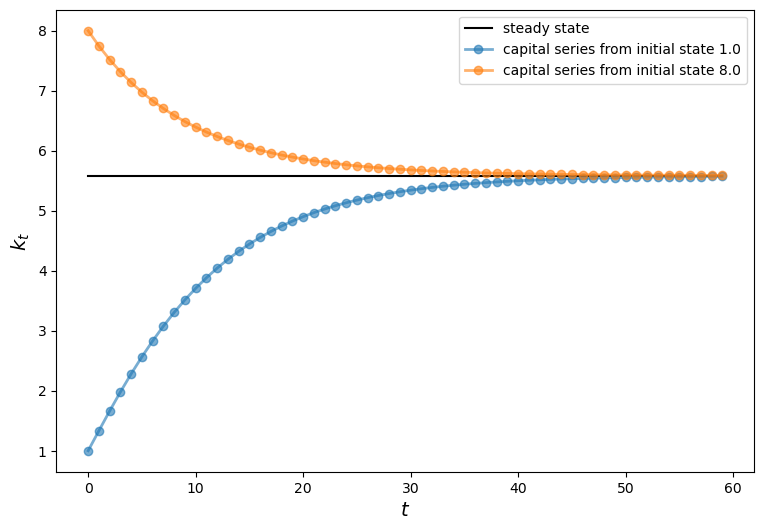

In [11]:
s1 = Solow()
s2 = Solow(k=8.0)

T = 60
fig,ax = plt.subplots(figsize=(9,6))

# Plot the common steady state value of capital
ax.plot([s1.steady_state()]*T, 'k-', label='steady state')

# Plot time series for each economy
for s in s1, s2:
    lb = f'capital series from initial state {s.k}'
    ax.plot(s.generate_sequence(T), 'o-', lw=2, alpha=0.6, label=lb)

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$k_t$', fontsize=14)
ax.legend()
plt.show()

### A Market

Next, let’s write a class for competitive market in which buyers and sellers are both price takers.

The market consists of the following objects:

A linear demand curve $Q = a_d -b_dp$

A linear supply curve $Q = a_z + b_z(p-t)$

Here

- $p$ is price paid by the buyer, $Q$ is quantity and $t$ is a per-unit tax.

- Other symbols are demand and supply parameters.

The class provides methods to compute various values of interest, including competitive equilibrium price and quantity, tax revenue raised, consumer surplus and producer surplus.

Here’s our implementation.

(It uses a function from SciPy called quad for numerical integration—a topic we will say more about later on.)

In [12]:
from scipy.integrate import quad

class Market:
    def __init__(self, ad, bd, az, bz, tax):
        """
        Set up market parameters.  All parameters are scalars.  See
        https://lectures.quantecon.org/py/python_oop.html for interpretation.

        """
        self.ad, self.bd, self.az, self.bz, self.tax = ad, bd, az, bz, tax
        if ad < az:
            raise ValueError('Insufficient demand.')
    def price(self):
        """
        Compute equilibrium price.
        Make P the subject after equating the two equations

        """
        return  (self.ad - self.az + self.bz * self.tax) / (self.bd + self.bz)
    
    def quantity(self):
        "Compute equilibrium quantity"
        return self.ad - self.bd*self.price()

    def consumer_surp(self):
        "Compute consumer surplus"
        # == Compute area under inverse demand function == #
        integrand = lambda x: (self.ad / self.bd) - (1 / self.bd) * x
        area, error = quad(integrand, 0, self.quantity())
        return area - self.price() * self.quantity()

    def producer_surp(self):
        "Compute producer surplus"
        #  == Compute area above inverse supply curve, excluding tax == #
        integrand = lambda x: -(self.az / self.bz) + (1 / self.bz) * x
        area, error = quad(integrand, 0, self.quantity())
        return (self.price() - self.tax) * self.quantity() - area
    def taxrev(self):
        "Compute tax revenue"
        return self.tax * self.quantity()

    def inverse_demand(self, x):
        "Compute inverse demand"
        return self.ad / self.bd - (1 / self.bd)* x

    def inverse_supply(self, x):
        "Compute inverse supply curve"
        return -(self.az / self.bz) + (1 / self.bz) * x + self.tax

    def inverse_supply_no_tax(self, x):
        "Compute inverse supply curve without tax"
        return -(self.az / self.bz) + (1 / self.bz) * x


In [18]:
# Here's a sample of usage
baseline_params = 15, .5, -2, .5, 
m = Market(*baseline_params) # * passes baseline_params as 15 0.5 -2 0.5 3 and not (15, 0.5, -2, 0.5, 3)
print("equilibrium price = ", m.price())

(15, 0.5, -2, 0.5, 3)
equilibrium price =  18.5


## Exercises

### Exercise 7.1
[Link](https://python-programming.quantecon.org/python_oop.html#:~:text=Exercise%207.1,clarity%2C%20not%20efficiency)

In [32]:
from random import  uniform
class ECDF:
    """ 
    Implementation the empirical cumulative distribution function (ecdf) corresponding to a sample

    """
    def __init__(self, observations):
        self.observations = observations
    
    def __call__(self,x):
        return  sum([i <= x for i in self.observations]) / len(self.observations) 



In [41]:
samples = [uniform(0, 1) for i in range(10)]
F = ECDF(samples)
F(0.5)  # Evaluate ecdf at x = 0.5

0.7

In [37]:
F.observations = [uniform(0, 1) for i in range(1000)]
F(0.5)

0.506

### Exercise 7.2

In an earlier exercise, you wrote a function for evaluating polynomials.

[This is an extension of the exercise](https://python-programming.quantecon.org/python_oop.html#:~:text=This%20exercise%20is,any%20import%20statements)

In [74]:
class Polynomial:
    def __init__(self, coeff):
        self.coeff = coeff
    
    def __call__(self,x):
        return sum(a * x**i for i, a in enumerate(self.coeff))
    
    def differentiate(self):
        coeff_list = [i * x for i, x in  enumerate(self.coeff)]
        del coeff_list[0]

        self.coeff = coeff_list


In [77]:
p = Polynomial((2,4,2,1))
print(p(1))

p.differentiate()
print(p(1))


9
11
